0.10584044081637653
[-5.494684109589116, -35.10679013698626, -72.14380465753419, -28.65933917808218, -11.95602136986309, -6.719830136986275, -32.55670602739735, -65.62042575342468, 18.59784301369871, -9.816816438356227, -37.7498978082192, -28.11349205479445, -55.87767479452054, -26.41674054794521, -25.78418109589046, -33.99408876712332, -39.98368082191783, -21.18149945205477, -9.07849041095892, -21.67282356164384, -106.2176550684931, -49.36000602739728, -38.35485972602739, -18.90800739726028, -15.42032493150685] [-24.83676602739735, -21.03837753424654, -28.83040876712329, -0.9740934246574966, -17.10626931506852, -44.50832547945203, -37.98306136986304, -16.44737643835612, 3.681251506849321, -37.16984657534249, -91.66445424657536, -49.22680575342463, -23.79555917808221, -17.57822438356163, -18.05422493150684, -27.56068931506849, -56.97675123287672, -30.21985643835615, -2.541796438356187, -23.36726191780821, -61.43452219178081, -34.5703194520548, -33.55890739726027, -19.58358904109589, -1

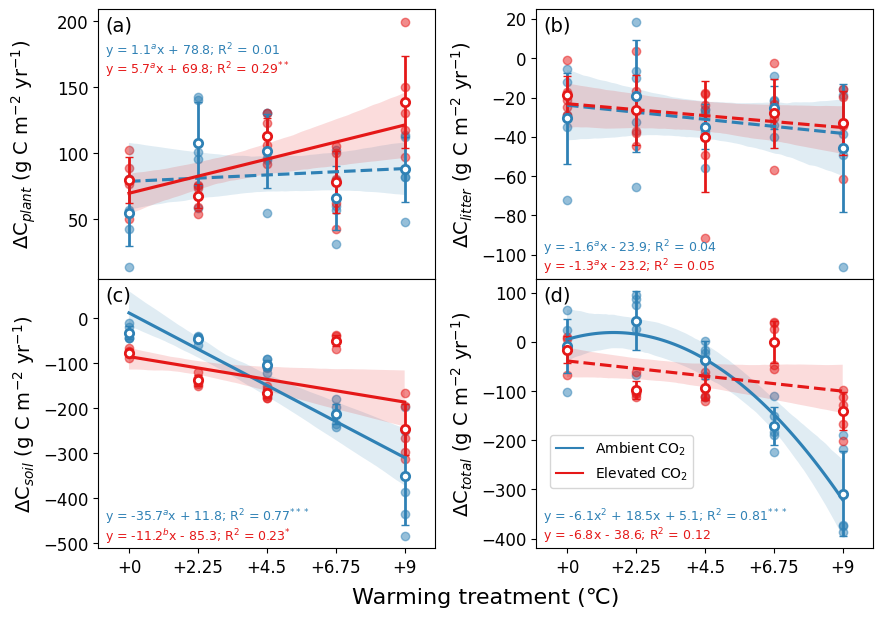

In [1]:
import pandas as pd
import numpy as np

df_data_mlm = pd.read_excel("/Users/jianzhou/MyDocs/1_works/1_proj_SPRUCE/1_SPRUCE_DA/4_summary_data_code_paper/test_output/2_mod_results/results_MLM/1_2_1_data_MLM/2_df_res_mlm_yrDel_nomean.xlsx")

var_names_in = ["plot", 'warming', 'year',
                "gpp_Tree",    "gpp_Shrub",    "gpp_Sphagnum", 
                "npp_Tree",    "npp_Shrub",    "npp_Sphagnum", 
                "ra_Tree",     "ra_Shrub",     "ra_Sphagnum",    "rh", 
                "del_C_plant_Tree", "del_C_plant_Shrub", "del_C_plant_Sphagnum", 
                "del_C_plant_above_Tree", "del_C_plant_above_Shrub", "del_C_plant_above_Sphagnum", 
                "del_C_plant_below_Tree", "del_C_plant_below_Shrub", "del_C_plant_below_Sphagnum", 
                "del_C_litter",     "del_C_soil", "del_C"]

# print(df_data_mlm.columns)
i_warmPlots  = [1, 9, 5, 2, 7]
i_warmEleCO2 = [8, 4, 0, 6, 3]

df_data = df_data_mlm[var_names_in]
df_data = df_data[df_data["year"] > 2016]


import statsmodels.api as sm
import statsmodels.formula.api as smf

def cal_reg_diff(x1, y1, x2, y2): # justify if there is significant difference between two groups data
    # create two group datasets
    x = np.concatenate([x1, x2])
    y = np.concatenate([y1, y2])
    group = np.array([1]*len(x1) + [2]*len(x2))  # 1: group one; 2: group two

    # create a model include interactive object
    data = {'y': y, 'x': x, 'group': group}
    model = smf.ols('y ~ x + group + x * C(group)', data=data).fit()

    pvalue_diff_slope     = model.pvalues['x:C(group)[T.2]']
    pvalue_diff_intercept = model.pvalues['C(group)[T.2]']

    if pvalue_diff_slope < 0.05:
        res_ab_slope = ("a", "b")
    else:
        res_ab_slope = ("a", "a")

    if pvalue_diff_intercept < 0.05:
        res_ab_intercept = ("a", "b")
    else:
        res_ab_intercept = ("a", "a")

    return res_ab_slope, res_ab_intercept


def compare_linear_quadratic(x,y):
    # add constant
    X1 = sm.add_constant(x)  # linear
    X2 = sm.add_constant(np.column_stack((x, x**2)))  # quadratic

    # create model
    model_linear = sm.OLS(y, X1).fit()
    model_quadratic = sm.OLS(y, X2).fit()

    # print(f"linear: AIC = {model_linear.aic}, BIC = {model_linear.bic}")
    # print(f"R-squared: {model_linear.rsquared}")
    # print(f"coef_slope: {model_linear.params[1]}, interpt: {model_linear.params[0]}")

    # print(f"quadratic: AIC = {model_quadratic.aic}, BIC = {model_quadratic.bic}")
    # print(f"R-squared: {model_quadratic.rsquared}")
    # print(f"coef_x2: {model_quadratic.params[-1]}, coef_x: {model_quadratic.params[1]}, interpt: {model_quadratic.params[0]}")

    # print(f"delta AIC (quadratic - linear): {model_quadratic.aic - model_linear.aic}")

    info_linear    = {"R2"       : model_linear.rsquared,
                      "pvalue"   : model_linear.f_pvalue, 
                      "slope"    : model_linear.params[1], 
                      "intercept": model_linear.params[0]} 
    info_quadratic = {"R2"       : model_quadratic.rsquared,
                      "pvalue"   : model_quadratic.f_pvalue, 
                      "x2"       : model_quadratic.params[-1], 
                      "x"        : model_quadratic.params[1],
                      "intercept": model_quadratic.params[0]}

    info_AIC_BIC = {
        "AIC_linear": model_linear.aic,
        "AIC_quadratic": model_quadratic.aic,
        "BIC_linear": model_linear.bic,
        "BIC_quadratic": model_quadratic.bic,
        "diff_AIC": model_linear.aic - model_quadratic.aic,
        "diff_BIC": model_linear.bic - model_quadratic.bic
    }

    return info_linear, info_quadratic, info_AIC_BIC

def check_pvalue(pvalue):
    if   pvalue < 0.001: 
        mark_p = "***"; line_style = "-"
    elif pvalue < 0.01: 
        mark_p = "**"; line_style = "-"
    elif pvalue < 0.05: 
        mark_p = "*"; line_style = "-"
    else: 
        mark_p = ""; line_style = "--"
    return mark_p, line_style


def check_negative(b, c=None):
    if c is None:
        if b < 0:
            ret_str = "y = {:.1f}$^{}$x - {:.1f}; R$^2$ = {:.2f}"
        else:
            ret_str = "y = {:.1f}$^{}$x + {:.1f}; R$^2$ = {:.2f}"
    else:
        if b < 0:
            if c < 0:
                ret_str = "y = {:.1f}x$^2$ - {:.1f}x - {:.1f}; R$^2$ = {:.2f}"
            else:
                ret_str = "y = {:.1f}x$^2$ - {:.1f}x + {:.1f}; R$^2$ = {:.2f}"
        else:
            if c < 0:
                ret_str = "y = {:.1f}x$^2$ + {:.1f}x - {:.1f}; R$^2$ = {:.2f}"
            else:
                ret_str = "y = {:.1f}x$^2$ + {:.1f}x + {:.1f}; R$^2$ = {:.2f}"
    return ret_str


# start to plot
import matplotlib.pyplot as plt
import seaborn as sns
# from scipy.stats import linregress
import matplotlib.ticker as ticker
from scipy import stats
from scipy.stats import mannwhitneyu

# import matplotlib as mpl
%matplotlib inline
# mpl.rcParams['text.usetex'] = False

def to_int(x, pos):
    return '{:.0f}'.format(x)


nrow = 2; ncol = 2

fig, axes = plt.subplots(nrow, ncol, figsize=(10,7)) 

# ls_subtitle = [["(a)", "(b)", "(c)"],
#                ["(d)", "(e)", "(f)"]]

ls_subtitle = [["(a)", "(b)"],
               ["(c)", "(d)"]]

ls_ylim = [[(400, 1950), (199, 579), (-719, 199)],
           [(-1350, -99), (-780, -151), (-280, 80)]]

# ls_pos  = [[(0.02, 0.81, 0.74), (0.02, 0.81, 0.74), (0.02, 0.1, 0.03)],
#            [(0.02, 0.1, 0.03), (0.02, 0.1, 0.03), (0.02, 0.1, 0.03)]]

ls_pos  = [[(0.02, 0.81, 0.74),(0.02, 0.08, 0.01)],
           [ (0.02, 0.08, 0.01), (0.02, 0.08, 0.01)]]

x_bar = [0, 2.25, 4.5, 6.75, 9]
custom_x_ticks  = [0,      2.25,    4.5,    6.75,    9]  # x stick
custom_x_labels = ['+0', '+2.25', '+4.5', '+6.75', '+9']  # x-axis label

# ls_vars = ["cplant", "cplant_above", "cplant_below", "clitter", "csoil", "cpool"]

ls_vars = ["cplant",  "clitter", "csoil", "cpool"]

idx_var = -1

for irow in range(nrow):
    for icol in range(ncol):
        ax = axes[irow, icol]
        idx_var += 1
        ivar = ls_vars[idx_var]
        # read data
        df_data_ivar = df_data[["plot", 'warming', 'year']]
        if ivar == "cplant":
            df_data_ivar = df_data_ivar.assign(dat_ivar = df_data["del_C_plant_Tree"] + df_data["del_C_plant_Shrub"] + df_data["del_C_plant_Sphagnum"])
        elif ivar == "cplant_above":
            df_data_ivar = df_data_ivar.assign(dat_ivar = df_data["del_C_plant_above_Tree"] + df_data["del_C_plant_above_Shrub"] + df_data["del_C_plant_above_Sphagnum"])
        elif ivar == "cplant_below":
            df_data_ivar = df_data_ivar.assign(dat_ivar = df_data["del_C_plant_below_Tree"] + df_data["del_C_plant_below_Shrub"] + df_data["del_C_plant_below_Sphagnum"])
        elif ivar == "clitter":
            df_data_ivar = df_data_ivar.assign(dat_ivar = df_data["del_C_litter"])
        elif ivar == "csoil":
            df_data_ivar = df_data_ivar.assign(dat_ivar = df_data["del_C_soil"])
        elif ivar == "cpool":
            df_data_ivar = df_data_ivar.assign(dat_ivar = df_data["del_C_plant_Tree"] + df_data["del_C_plant_Shrub"] + df_data["del_C_plant_Sphagnum"] + 
                                           df_data["del_C_litter"] + df_data["del_C_soil"])
        
        # handle data
        x           = []
        y_aco2      = []
        y_eco2      = []
        y_mean_aco2 = []
        y_mean_eco2 = []
        y_std_aco2  = []
        y_std_eco2  = []
        
        for iwarm, ico2 in zip(i_warmPlots, i_warmEleCO2):
            x.extend(df_data_ivar[df_data_ivar["plot"]==ico2]["warming"])
            ls_dat_aco2 =(df_data_ivar[df_data_ivar["plot"]==iwarm]["dat_ivar"]).to_numpy().flatten().tolist()
            y_aco2.extend(ls_dat_aco2)
            y_mean_aco2.append(np.nanmean(np.array(ls_dat_aco2)))
            y_std_aco2.append(np.nanstd(np.array(ls_dat_aco2)))
            # -----------------------------------------------------------------
            ls_dat_eco2 =(df_data_ivar[df_data_ivar["plot"]==ico2]["dat_ivar"]).to_numpy().flatten().tolist()
            y_eco2.extend(ls_dat_eco2)
            y_mean_eco2.append(np.nanmean(np.array(ls_dat_eco2)))
            y_std_eco2.append(np.nanstd(np.array(ls_dat_eco2)))
            
        if irow == 0 and icol == 1: print(y_aco2, y_eco2)
        if irow == 0 and icol == 2: print(y_aco2, y_eco2)
        if irow == 1 and icol == 2: print(y_aco2, y_eco2)
        ax.scatter(x,y_aco2,alpha=0.5,color="#2F81B5",zorder=1)
        ax.scatter(x,y_eco2,alpha=0.5,color="#E51818",zorder=1)
        ax.errorbar(x_bar, y_mean_aco2, yerr=[np.array(y_std_aco2), np.array(y_std_aco2)], fmt='none', ecolor='#2F81B5', capsize=3, linewidth=2,zorder=2)
        ax.errorbar(x_bar, y_mean_eco2, yerr=[np.array(y_std_eco2), np.array(y_std_eco2)], fmt='none', ecolor='#E51818', capsize=3, linewidth=2,zorder=2)
        ax.scatter(x_bar, y_mean_aco2, marker='o', color='white', edgecolors='#2F81B5', linewidth=2, zorder=3)
        ax.scatter(x_bar, y_mean_eco2, marker='o', color='white', edgecolors='#E51818', linewidth=2, zorder=3)

        # t_stat, p_value = stats.ttest_ind(y_aco2, y_eco2)
        # t_stat, p_value = stats.ttest_rel(y_aco2, y_eco2)
        # t_stat, p_value = mannwhitneyu(y_aco2, y_eco2)
        t_stat, p_value = stats.ttest_1samp(np.array(y_eco2) - np.array(y_aco2), 0)
        print(p_value)

        # linear and quadratic test
        info_linear_aco2, info_quadratic_aco2, info_diff_aco2 = compare_linear_quadratic(np.array(x), np.array(y_aco2))
        info_linear_eco2, info_quadratic_eco2, info_diff_eco2 = compare_linear_quadratic(np.array(x), np.array(y_eco2))

        # check if significant different
        if idx_var < 3: #5 :
            res_ab_slope, res_ab_intercept = cal_reg_diff(np.array(x), np.array(y_aco2), np.array(x), np.array(y_eco2))
        else:
            res_ab_slope, res_ab_intercept = ('\u200B', '\u200B'), ('\u200B', '\u200B')
        
        # linear or quadratic
        if idx_var < 3: #< 5:
            info_aco2 = info_linear_aco2; order_aco2 = 1
            mark_p, line_style = check_pvalue(info_aco2["pvalue"])
            # if idx_var == 1:
            #     ax.text(ls_pos[irow][icol][0], ls_pos[irow][icol][1], 
            #         # "y$^{}$ = {:.1f}$^{}$x + {:.1f}; R$^2$ = {:.2f}".format(mark_p_y[0],info_aco2["slope"],res_ab_slope[0],info_aco2["intercept"],info_aco2["R2"])+"$^{"+mark_p+"}$", 
            #         "y = {:.1f}$^{}$x + {:.1f}; R$^2$ < {:.2f}".format(info_aco2["slope"],res_ab_slope[0],abs(info_aco2["intercept"]),0.01)+"$^{"+mark_p+"}$",
            #         fontsize=9, transform=ax.transAxes, color="#2F81B5", va='bottom')
            # else:
            ax.text(ls_pos[irow][icol][0], ls_pos[irow][icol][1], 
                # "y$^{}$ = {:.1f}$^{}$x + {:.1f}; R$^2$ = {:.2f}".format(mark_p_y[0],info_aco2["slope"],res_ab_slope[0],info_aco2["intercept"],info_aco2["R2"])+"$^{"+mark_p+"}$", 
                check_negative(info_aco2["intercept"]).format(info_aco2["slope"],res_ab_slope[0],abs(info_aco2["intercept"]),info_aco2["R2"])+"$^{"+mark_p+"}$",
                fontsize=9, transform=ax.transAxes, color="#2F81B5", va='bottom')
        else: 
            info_aco2 = info_quadratic_aco2; order_aco2 = 2
            mark_p, line_style = check_pvalue(info_aco2["pvalue"])
            ax.text(ls_pos[irow][icol][0], ls_pos[irow][icol][1], 
                    # "y$^{}$ = {:.1f}x$^2$ + {:.1f}x + {:.1f}; R$^2$ = {:.2f}".format(mark_p_y[0],info_aco2["x2"],info_aco2["x"],info_aco2["intercept"], info_aco2["R2"])+"$^{"+mark_p+"}$", 
                    check_negative(info_aco2["x"], info_aco2["intercept"]).format(info_aco2["x2"],abs(info_aco2["x"]),abs(info_aco2["intercept"]), info_aco2["R2"])+"$^{"+mark_p+"}$", 
                    fontsize=9, transform=ax.transAxes, color="#2F81B5", va='bottom')

        
        sns.regplot(x=x, y=y_aco2, order=order_aco2,ax=ax, scatter_kws={'alpha': 0.7, 'color':"#00857B"},line_kws={"linestyle": line_style}, scatter=False, color="#2F81B5") #, color="#2F81B5",  label="Ambient CO$_2$")
        
        
        # print("eCO2 ---", ivar,"------abs--", abs(info_diff_eco2["diff_AIC"]))
        if idx_var < 6:
            info_eco2 = info_linear_eco2; order_eco2 = 1
            mark_p, line_style = check_pvalue(info_eco2["pvalue"])
            ax.text(ls_pos[irow][icol][0], ls_pos[irow][icol][2], 
                    # "y$^{}$ = {:.1f}$^{}$x + {:.1f}; R$^2$ = {:.2f}".format(mark_p_y[1],info_eco2["slope"],res_ab_slope[1],info_eco2["intercept"],info_eco2["R2"])+"$^{"+mark_p+"}$", 
                    check_negative(info_eco2["intercept"]).format(info_eco2["slope"],res_ab_slope[1],abs(info_eco2["intercept"]),info_eco2["R2"])+"$^{"+mark_p+"}$", 
                    fontsize=9, transform=ax.transAxes, color="#E51818", va='bottom')
            
        else: 
            info_eco2 = info_quadratic_eco2; order_eco2 = 2
            mark_p, line_style = check_pvalue(info_eco2["pvalue"])
            ax.text(ls_pos[irow][icol][0], ls_pos[irow][icol][2], 
                    # "y$^{}$ = {:.1f}x$^2$ + {:.1f}x + {:.1f}; R$^2$ = {:.2f}".format(mark_p_y[1],info_eco2["x2"],info_eco2["x"],info_eco2["intercept"], info_eco2["R2"])+"$^{"+mark_p+"}$", 
                    check_negative(info_eco2["x"],info_eco2["intercept"]).format(info_eco2["x2"],abs(info_eco2["x"]),abs(info_eco2["intercept"]), info_eco2["R2"])+"$^{"+mark_p+"}$", 
                    fontsize=9, transform=ax.transAxes, color="#E51818", va='bottom')

            # ax.text(ls_pos[irow][icol][0], ls_pos[irow][icol][2], "y = {:.1f}x$^2$ + {:.1f}x - {:.1f}; R$^2$ = {:.2f}".format(coefficients[-1],coefficients[1],-coefficients[0],r_squared)+"$^{"+mark_p+"}$", fontsize=10, transform=ax.transAxes, color="#2F81B5", va='bottom')

        if info_eco2["pvalue"] < 0.001: mark_p = "***"; line_style = "-"
        elif info_eco2["pvalue"] < 0.01: mark_p = "**"; line_style = "-"
        elif info_eco2["pvalue"] < 0.05: mark_p = "*"; line_style = "-"
        else: mark_p = ""; line_style = "--"
        sns.regplot(x=x, y=y_eco2, order=order_eco2,ax=ax, scatter_kws={'alpha': 0.7, 'color':"#00857B"},line_kws={"linestyle": line_style},scatter=False, color="#E51818")

        ax.set_xticks(custom_x_ticks, custom_x_labels, fontsize=12)
        ax.tick_params(axis='x', labelsize=12)  # x-axis ticks font size
        ax.tick_params(axis='y', labelsize=12)  # y-axis ticks font size

        ax.text(0.02, 0.92, ls_subtitle[irow][icol], fontsize=14, transform=ax.transAxes)
        ax.set_xlim(-1, 10)
        # ax.set_ylim(ls_ylim[irow][icol][0], ls_ylim[irow][icol][1])
        

import matplotlib.lines as mlines
# 创建图例句柄
blue_line = mlines.Line2D([], [], color='#2F81B5', linestyle = "-", label='Ambient CO$_2$')
green_line = mlines.Line2D([], [], color='#E51818', linestyle = "-", label='Elevated CO$_2$')

# 添加图例
ax.legend(bbox_to_anchor=(0.02, 0.2), loc='lower left', handles=[blue_line, green_line])
# ax.legend(loc='upper right', handles=[blue_line, green_line])


# axes[0,2].set_ylim(-45,60)
# axes[1,2].axis("off")

axes[0,0].text(-0.22, 0.5, "ΔC$_{plant}$ (g C m$^{-2}$ yr$^{-1}$)", ha='center', va='center',rotation='vertical',transform=axes[0,0].transAxes, fontsize=14)
# axes[0,1].text(-0.24, 0.5, "ΔC$_{above}$ (g C m$^{-2}$ yr$^{-1}$)", ha='center', va='center',rotation='vertical',transform=axes[0,1].transAxes, fontsize=14)
# axes[0,2].text(-0.24, 0.5, "ΔC$_{below}$ (g C m$^{-2}$ yr$^{-1}$)", ha='center', va='center',rotation='vertical',transform=axes[0,2].transAxes, fontsize=14)
axes[0,1].text(-0.22, 0.5, "ΔC$_{litter}$ (g C m$^{-2}$ yr$^{-1}$)", ha='center', va='center',rotation='vertical',transform=axes[0,1].transAxes, fontsize=14)
axes[1,0].text(-0.22, 0.5, "ΔC$_{soil}$ (g C m$^{-2}$ yr$^{-1}$)", ha='center', va='center',rotation='vertical',transform=axes[1,0].transAxes, fontsize=14)
axes[1,1].text(-0.22, 0.5, "ΔC$_{total}$ (g C m$^{-2}$ yr$^{-1}$)", ha='center', va='center',rotation='vertical',transform=axes[1,1].transAxes, fontsize=14)


ax.set_xticks(custom_x_ticks, custom_x_labels, fontsize=12)
axes[1,1].text(-0.15, -0.18, "Warming treatment (℃)", fontsize=16, ha='center', va='center', transform=axes[1,1].transAxes)


plt.subplots_adjust(hspace=0, wspace=0.3)

0.7361444477919237
[-6.87867431506851, -17.63040712328766, -23.560094794520552, -1.2741710273972582, 9.994600479452055, 39.02651445205481, 7.279592191780807, -12.837142808219163, -5.897201438356177, 13.602464520547969, 39.045743972602736, 9.538416849315048, -17.623620342465745, -5.687692876712312, 14.355740342465753, 21.689029520547937, 0.33685602739727116, -10.923743424657523, -4.597592191780853, 7.618060205479464, 11.787112602739725, 4.306088561643843, -3.403224999999992, -1.700183013698638, 2.137629383561641] [-3.06031801369862, -6.841314246575329, -11.644365136986316, -3.570052602739718, 1.9838273287671162, 11.440061917808228, 9.769950958904108, 4.540156232876709, 1.6903530821917716, 5.972054178082193, 51.7489587671233, 42.33339102739725, 19.691847123287687, 21.737751164383535, 30.222730410958917, 22.9578223287671, 4.67677006849317, -7.619911849315089, 7.08892958904114, 14.696141301369835, 24.590782123287656, 16.94229232876714, 10.150144520547947, 16.920720342465742, 32.01143452054

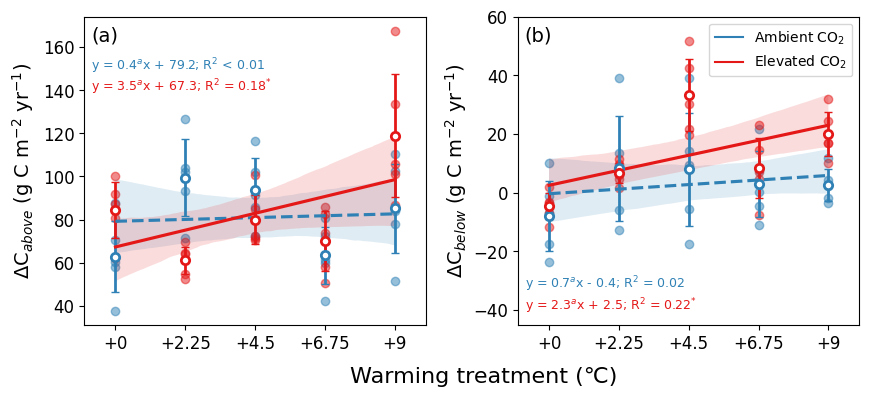

In [2]:
import pandas as pd
import numpy as np

df_data_mlm = pd.read_excel("/Users/jianzhou/MyDocs/1_works/1_proj_SPRUCE/1_SPRUCE_DA/4_summary_data_code_paper/test_output/2_mod_results/results_MLM/1_2_1_data_MLM/2_df_res_mlm_yrDel_nomean.xlsx")

var_names_in = ["plot", 'warming', 'year',
                "gpp_Tree",    "gpp_Shrub",    "gpp_Sphagnum", 
                "npp_Tree",    "npp_Shrub",    "npp_Sphagnum", 
                "ra_Tree",     "ra_Shrub",     "ra_Sphagnum",    "rh", 
                "del_C_plant_Tree", "del_C_plant_Shrub", "del_C_plant_Sphagnum", 
                "del_C_plant_above_Tree", "del_C_plant_above_Shrub", "del_C_plant_above_Sphagnum", 
                "del_C_plant_below_Tree", "del_C_plant_below_Shrub", "del_C_plant_below_Sphagnum", 
                "del_C_litter",     "del_C_soil", "del_C"]

# print(df_data_mlm.columns)
i_warmPlots  = [1, 9, 5, 2, 7]
i_warmEleCO2 = [8, 4, 0, 6, 3]

df_data = df_data_mlm[var_names_in]
df_data = df_data[df_data["year"] > 2016]


import statsmodels.api as sm
import statsmodels.formula.api as smf

def cal_reg_diff(x1, y1, x2, y2): # justify if there is significant difference between two groups data
    # create two group datasets
    x = np.concatenate([x1, x2])
    y = np.concatenate([y1, y2])
    group = np.array([1]*len(x1) + [2]*len(x2))  # 1: group one; 2: group two

    # create a model include interactive object
    data = {'y': y, 'x': x, 'group': group}
    model = smf.ols('y ~ x + group + x * C(group)', data=data).fit()

    pvalue_diff_slope     = model.pvalues['x:C(group)[T.2]']
    pvalue_diff_intercept = model.pvalues['C(group)[T.2]']

    if pvalue_diff_slope < 0.05:
        res_ab_slope = ("a", "b")
    else:
        res_ab_slope = ("a", "a")

    if pvalue_diff_intercept < 0.05:
        res_ab_intercept = ("a", "b")
    else:
        res_ab_intercept = ("a", "a")

    return res_ab_slope, res_ab_intercept


def compare_linear_quadratic(x,y):
    # add constant
    X1 = sm.add_constant(x)  # linear
    X2 = sm.add_constant(np.column_stack((x, x**2)))  # quadratic

    # create model
    model_linear = sm.OLS(y, X1).fit()
    model_quadratic = sm.OLS(y, X2).fit()

    # print(f"linear: AIC = {model_linear.aic}, BIC = {model_linear.bic}")
    # print(f"R-squared: {model_linear.rsquared}")
    # print(f"coef_slope: {model_linear.params[1]}, interpt: {model_linear.params[0]}")

    # print(f"quadratic: AIC = {model_quadratic.aic}, BIC = {model_quadratic.bic}")
    # print(f"R-squared: {model_quadratic.rsquared}")
    # print(f"coef_x2: {model_quadratic.params[-1]}, coef_x: {model_quadratic.params[1]}, interpt: {model_quadratic.params[0]}")

    # print(f"delta AIC (quadratic - linear): {model_quadratic.aic - model_linear.aic}")

    info_linear    = {"R2"       : model_linear.rsquared,
                      "pvalue"   : model_linear.f_pvalue, 
                      "slope"    : model_linear.params[1], 
                      "intercept": model_linear.params[0]} 
    info_quadratic = {"R2"       : model_quadratic.rsquared,
                      "pvalue"   : model_quadratic.f_pvalue, 
                      "x2"       : model_quadratic.params[-1], 
                      "x"        : model_quadratic.params[1],
                      "intercept": model_quadratic.params[0]}

    info_AIC_BIC = {
        "AIC_linear": model_linear.aic,
        "AIC_quadratic": model_quadratic.aic,
        "BIC_linear": model_linear.bic,
        "BIC_quadratic": model_quadratic.bic,
        "diff_AIC": model_linear.aic - model_quadratic.aic,
        "diff_BIC": model_linear.bic - model_quadratic.bic
    }

    return info_linear, info_quadratic, info_AIC_BIC

def check_pvalue(pvalue):
    if   pvalue < 0.001: 
        mark_p = "***"; line_style = "-"
    elif pvalue < 0.01: 
        mark_p = "**"; line_style = "-"
    elif pvalue < 0.05: 
        mark_p = "*"; line_style = "-"
    else: 
        mark_p = ""; line_style = "--"
    return mark_p, line_style


def check_negative(b, c=None):
    if c is None:
        if b < 0:
            ret_str = "y = {:.1f}$^{}$x - {:.1f}; R$^2$ = {:.2f}"
        else:
            ret_str = "y = {:.1f}$^{}$x + {:.1f}; R$^2$ = {:.2f}"
    else:
        if b < 0:
            if c < 0:
                ret_str = "y = {:.1f}x$^2$ - {:.1f}x - {:.1f}; R$^2$ = {:.2f}"
            else:
                ret_str = "y = {:.1f}x$^2$ - {:.1f}x + {:.1f}; R$^2$ = {:.2f}"
        else:
            if c < 0:
                ret_str = "y = {:.1f}x$^2$ + {:.1f}x - {:.1f}; R$^2$ = {:.2f}"
            else:
                ret_str = "y = {:.1f}x$^2$ + {:.1f}x + {:.1f}; R$^2$ = {:.2f}"
    return ret_str


# start to plot
import matplotlib.pyplot as plt
import seaborn as sns
# from scipy.stats import linregress
import matplotlib.ticker as ticker
from scipy import stats
from scipy.stats import mannwhitneyu

# import matplotlib as mpl
%matplotlib inline
# mpl.rcParams['text.usetex'] = False

def to_int(x, pos):
    return '{:.0f}'.format(x)


nrow = 1; ncol = 2

fig, axes = plt.subplots(nrow, ncol, figsize=(10,4)) 
# fig, axes = plt.subplots(nrow, ncol, figsize=(15,7)) 

ls_subtitle = [["(a)", "(b)", "(c)"],
               ["(d)", "(e)", "(f)"]]

ls_ylim = [[(400, 1950), (199, 579), (-719, 199)],
           [(-1350, -99), (-780, -151), (-280, 80)]]

# ls_pos  = [[(0.02, 0.81, 0.74), (0.02, 0.81, 0.74), (0.02, 0.1, 0.03)],
#            [(0.02, 0.1, 0.03), (0.02, 0.1, 0.03), (0.02, 0.1, 0.03)]]

ls_pos  = [[(0.02, 0.81, 0.74), (0.02, 0.1, 0.03), (0.02, 0.1, 0.03)],
           [(0.02, 0.1, 0.03), (0.02, 0.1, 0.03), (0.02, 0.1, 0.03)]]

x_bar = [0, 2.25, 4.5, 6.75, 9]
custom_x_ticks  = [0,      2.25,    4.5,    6.75,    9]  # x stick
custom_x_labels = ['+0', '+2.25', '+4.5', '+6.75', '+9']  # x-axis label

# ls_vars = ["cplant", "cplant_above", "cplant_below", "clitter", "csoil", "cpool"]

ls_vars = [ "cplant_above", "cplant_below"]

idx_var = -1

for irow in range(nrow):
    for icol in range(ncol):
        ax = axes[icol] #axes[irow, icol]
        idx_var += 1
        ivar = ls_vars[idx_var]
        # read data
        df_data_ivar = df_data[["plot", 'warming', 'year']]
        if ivar == "cplant":
            df_data_ivar = df_data_ivar.assign(dat_ivar = df_data["del_C_plant_Tree"] + df_data["del_C_plant_Shrub"] + df_data["del_C_plant_Sphagnum"])
        elif ivar == "cplant_above":
            df_data_ivar = df_data_ivar.assign(dat_ivar = df_data["del_C_plant_above_Tree"] + df_data["del_C_plant_above_Shrub"] + df_data["del_C_plant_above_Sphagnum"])
        elif ivar == "cplant_below":
            df_data_ivar = df_data_ivar.assign(dat_ivar = df_data["del_C_plant_below_Tree"] + df_data["del_C_plant_below_Shrub"] + df_data["del_C_plant_below_Sphagnum"])
        elif ivar == "clitter":
            df_data_ivar = df_data_ivar.assign(dat_ivar = df_data["del_C_litter"])
        elif ivar == "csoil":
            df_data_ivar = df_data_ivar.assign(dat_ivar = df_data["del_C_soil"])
        elif ivar == "cpool":
            df_data_ivar = df_data_ivar.assign(dat_ivar = df_data["del_C_plant_Tree"] + df_data["del_C_plant_Shrub"] + df_data["del_C_plant_Sphagnum"] + 
                                           df_data["del_C_litter"] + df_data["del_C_soil"])
        
        # handle data
        x           = []
        y_aco2      = []
        y_eco2      = []
        y_mean_aco2 = []
        y_mean_eco2 = []
        y_std_aco2  = []
        y_std_eco2  = []
        
        for iwarm, ico2 in zip(i_warmPlots, i_warmEleCO2):
            x.extend(df_data_ivar[df_data_ivar["plot"]==ico2]["warming"])
            ls_dat_aco2 =(df_data_ivar[df_data_ivar["plot"]==iwarm]["dat_ivar"]).to_numpy().flatten().tolist()
            y_aco2.extend(ls_dat_aco2)
            y_mean_aco2.append(np.nanmean(np.array(ls_dat_aco2)))
            y_std_aco2.append(np.nanstd(np.array(ls_dat_aco2)))
            # -----------------------------------------------------------------
            ls_dat_eco2 =(df_data_ivar[df_data_ivar["plot"]==ico2]["dat_ivar"]).to_numpy().flatten().tolist()
            y_eco2.extend(ls_dat_eco2)
            y_mean_eco2.append(np.nanmean(np.array(ls_dat_eco2)))
            y_std_eco2.append(np.nanstd(np.array(ls_dat_eco2)))
            
        if irow == 0 and icol == 1: print(y_aco2, y_eco2)
        if irow == 0 and icol == 2: print(y_aco2, y_eco2)
        if irow == 1 and icol == 2: print(y_aco2, y_eco2)
        ax.scatter(x,y_aco2,alpha=0.5,color="#2F81B5",zorder=1)
        ax.scatter(x,y_eco2,alpha=0.5,color="#E51818",zorder=1)
        ax.errorbar(x_bar, y_mean_aco2, yerr=[np.array(y_std_aco2), np.array(y_std_aco2)], fmt='none', ecolor='#2F81B5', capsize=3, linewidth=2,zorder=2)
        ax.errorbar(x_bar, y_mean_eco2, yerr=[np.array(y_std_eco2), np.array(y_std_eco2)], fmt='none', ecolor='#E51818', capsize=3, linewidth=2,zorder=2)
        ax.scatter(x_bar, y_mean_aco2, marker='o', color='white', edgecolors='#2F81B5', linewidth=2, zorder=3)
        ax.scatter(x_bar, y_mean_eco2, marker='o', color='white', edgecolors='#E51818', linewidth=2, zorder=3)

        # t_stat, p_value = stats.ttest_ind(y_aco2, y_eco2)
        # t_stat, p_value = stats.ttest_rel(y_aco2, y_eco2)
        # t_stat, p_value = mannwhitneyu(y_aco2, y_eco2)
        t_stat, p_value = stats.ttest_1samp(np.array(y_eco2) - np.array(y_aco2), 0)
        print(p_value)

        # linear and quadratic test
        info_linear_aco2, info_quadratic_aco2, info_diff_aco2 = compare_linear_quadratic(np.array(x), np.array(y_aco2))
        info_linear_eco2, info_quadratic_eco2, info_diff_eco2 = compare_linear_quadratic(np.array(x), np.array(y_eco2))

        # check if significant different
        if idx_var < 5 :
            res_ab_slope, res_ab_intercept = cal_reg_diff(np.array(x), np.array(y_aco2), np.array(x), np.array(y_eco2))
        else:
            res_ab_slope, res_ab_intercept = ('\u200B', '\u200B'), ('\u200B', '\u200B')
        
        # linear or quadratic
        if idx_var < 5:
            info_aco2 = info_linear_aco2; order_aco2 = 1
            mark_p, line_style = check_pvalue(info_aco2["pvalue"])
            if idx_var == 0:
                ax.text(ls_pos[irow][icol][0], ls_pos[irow][icol][1], 
                    # "y$^{}$ = {:.1f}$^{}$x + {:.1f}; R$^2$ = {:.2f}".format(mark_p_y[0],info_aco2["slope"],res_ab_slope[0],info_aco2["intercept"],info_aco2["R2"])+"$^{"+mark_p+"}$", 
                    "y = {:.1f}$^{}$x + {:.1f}; R$^2$ < {:.2f}".format(info_aco2["slope"],res_ab_slope[0],abs(info_aco2["intercept"]),0.01)+"$^{"+mark_p+"}$",
                    fontsize=9, transform=ax.transAxes, color="#2F81B5", va='bottom')
            else:
                ax.text(ls_pos[irow][icol][0], ls_pos[irow][icol][1], 
                    # "y$^{}$ = {:.1f}$^{}$x + {:.1f}; R$^2$ = {:.2f}".format(mark_p_y[0],info_aco2["slope"],res_ab_slope[0],info_aco2["intercept"],info_aco2["R2"])+"$^{"+mark_p+"}$", 
                    check_negative(info_aco2["intercept"]).format(info_aco2["slope"],res_ab_slope[0],abs(info_aco2["intercept"]),info_aco2["R2"])+"$^{"+mark_p+"}$",
                    fontsize=9, transform=ax.transAxes, color="#2F81B5", va='bottom')
        else: 
            info_aco2 = info_quadratic_aco2; order_aco2 = 2
            mark_p, line_style = check_pvalue(info_aco2["pvalue"])
            ax.text(ls_pos[irow][icol][0], ls_pos[irow][icol][1], 
                    # "y$^{}$ = {:.1f}x$^2$ + {:.1f}x + {:.1f}; R$^2$ = {:.2f}".format(mark_p_y[0],info_aco2["x2"],info_aco2["x"],info_aco2["intercept"], info_aco2["R2"])+"$^{"+mark_p+"}$", 
                    check_negative(info_aco2["x"], info_aco2["intercept"]).format(info_aco2["x2"],abs(info_aco2["x"]),abs(info_aco2["intercept"]), info_aco2["R2"])+"$^{"+mark_p+"}$", 
                    fontsize=9, transform=ax.transAxes, color="#2F81B5", va='bottom')

        
        sns.regplot(x=x, y=y_aco2, order=order_aco2,ax=ax, scatter_kws={'alpha': 0.7, 'color':"#00857B"},line_kws={"linestyle": line_style}, scatter=False, color="#2F81B5") #, color="#2F81B5",  label="Ambient CO$_2$")
        
        
        # print("eCO2 ---", ivar,"------abs--", abs(info_diff_eco2["diff_AIC"]))
        if idx_var < 6:
            info_eco2 = info_linear_eco2; order_eco2 = 1
            mark_p, line_style = check_pvalue(info_eco2["pvalue"])
            ax.text(ls_pos[irow][icol][0], ls_pos[irow][icol][2], 
                    # "y$^{}$ = {:.1f}$^{}$x + {:.1f}; R$^2$ = {:.2f}".format(mark_p_y[1],info_eco2["slope"],res_ab_slope[1],info_eco2["intercept"],info_eco2["R2"])+"$^{"+mark_p+"}$", 
                    check_negative(info_eco2["intercept"]).format(info_eco2["slope"],res_ab_slope[1],abs(info_eco2["intercept"]),info_eco2["R2"])+"$^{"+mark_p+"}$", 
                    fontsize=9, transform=ax.transAxes, color="#E51818", va='bottom')
            
        else: 
            info_eco2 = info_quadratic_eco2; order_eco2 = 2
            mark_p, line_style = check_pvalue(info_eco2["pvalue"])
            ax.text(ls_pos[irow][icol][0], ls_pos[irow][icol][2], 
                    # "y$^{}$ = {:.1f}x$^2$ + {:.1f}x + {:.1f}; R$^2$ = {:.2f}".format(mark_p_y[1],info_eco2["x2"],info_eco2["x"],info_eco2["intercept"], info_eco2["R2"])+"$^{"+mark_p+"}$", 
                    check_negative(info_eco2["x"],info_eco2["intercept"]).format(info_eco2["x2"],abs(info_eco2["x"]),abs(info_eco2["intercept"]), info_eco2["R2"])+"$^{"+mark_p+"}$", 
                    fontsize=9, transform=ax.transAxes, color="#E51818", va='bottom')

            # ax.text(ls_pos[irow][icol][0], ls_pos[irow][icol][2], "y = {:.1f}x$^2$ + {:.1f}x - {:.1f}; R$^2$ = {:.2f}".format(coefficients[-1],coefficients[1],-coefficients[0],r_squared)+"$^{"+mark_p+"}$", fontsize=10, transform=ax.transAxes, color="#2F81B5", va='bottom')

        if info_eco2["pvalue"] < 0.001: mark_p = "***"; line_style = "-"
        elif info_eco2["pvalue"] < 0.01: mark_p = "**"; line_style = "-"
        elif info_eco2["pvalue"] < 0.05: mark_p = "*"; line_style = "-"
        else: mark_p = ""; line_style = "--"
        sns.regplot(x=x, y=y_eco2, order=order_eco2,ax=ax, scatter_kws={'alpha': 0.7, 'color':"#00857B"},line_kws={"linestyle": line_style},scatter=False, color="#E51818")

        ax.set_xticks(custom_x_ticks, custom_x_labels, fontsize=12)
        ax.tick_params(axis='x', labelsize=12)  # x-axis ticks font size
        ax.tick_params(axis='y', labelsize=12)  # y-axis ticks font size

        ax.text(0.02, 0.92, ls_subtitle[irow][icol], fontsize=14, transform=ax.transAxes)
        ax.set_xlim(-1, 10)
        # ax.set_ylim(ls_ylim[irow][icol][0], ls_ylim[irow][icol][1])
        

import matplotlib.lines as mlines
# 创建图例句柄
blue_line = mlines.Line2D([], [], color='#2F81B5', linestyle = "-", label='Ambient CO$_2$')
green_line = mlines.Line2D([], [], color='#E51818', linestyle = "-", label='Elevated CO$_2$')

# 添加图例
# ax.legend(bbox_to_anchor=(0.02, 0.2), loc='lower left', handles=[blue_line, green_line])
ax.legend(loc='upper right', handles=[blue_line, green_line])


axes[1].set_ylim(-45,60)
# axes[1,2].axis("off")

# axes[0,0].text(-0.24, 0.5, "ΔC$_{plant}$ (g C m$^{-2}$ yr$^{-1}$)", ha='center', va='center',rotation='vertical',transform=axes[0,0].transAxes, fontsize=14)
# axes[0,1].text(-0.24, 0.5, "ΔC$_{above}$ (g C m$^{-2}$ yr$^{-1}$)", ha='center', va='center',rotation='vertical',transform=axes[0,1].transAxes, fontsize=14)
# axes[0,2].text(-0.24, 0.5, "ΔC$_{below}$ (g C m$^{-2}$ yr$^{-1}$)", ha='center', va='center',rotation='vertical',transform=axes[0,2].transAxes, fontsize=14)
# axes[1,0].text(-0.24, 0.5, "ΔC$_{litter}$ (g C m$^{-2}$ yr$^{-1}$)", ha='center', va='center',rotation='vertical',transform=axes[1,0].transAxes, fontsize=14)
# axes[1,1].text(-0.24, 0.5, "ΔC$_{soil}$ (g C m$^{-2}$ yr$^{-1}$)", ha='center', va='center',rotation='vertical',transform=axes[1,1].transAxes, fontsize=14)
# axes[1,2].text(-0.24, 0.5, "ΔC$_{total}$ (g C m$^{-2}$ yr$^{-1}$)", ha='center', va='center',rotation='vertical',transform=axes[1,2].transAxes, fontsize=14)

# axes[0,0].text(-0.24, 0.5, "ΔC$_{plant}$ (g C m$^{-2}$ yr$^{-1}$)", ha='center', va='center',rotation='vertical',transform=axes[0,0].transAxes, fontsize=14)
axes[0].text(-0.18, 0.5, "ΔC$_{above}$ (g C m$^{-2}$ yr$^{-1}$)", ha='center', va='center',rotation='vertical',transform=axes[0].transAxes, fontsize=14)
axes[1].text(-0.18, 0.5, "ΔC$_{below}$ (g C m$^{-2}$ yr$^{-1}$)", ha='center', va='center',rotation='vertical',transform=axes[1].transAxes, fontsize=14)
# axes[1,0].text(-0.24, 0.5, "ΔC$_{litter}$ (g C m$^{-2}$ yr$^{-1}$)", ha='center', va='center',rotation='vertical',transform=axes[1,0].transAxes, fontsize=14)
# axes[1,1].text(-0.24, 0.5, "ΔC$_{soil}$ (g C m$^{-2}$ yr$^{-1}$)", ha='center', va='center',rotation='vertical',transform=axes[1,1].transAxes, fontsize=14)
# axes[1,2].text(-0.24, 0.5, "ΔC$_{total}$ (g C m$^{-2}$ yr$^{-1}$)", ha='center', va='center',rotation='vertical',transform=axes[1,2].transAxes, fontsize=14)


ax.set_xticks(custom_x_ticks, custom_x_labels, fontsize=12)
axes[1].text(-0.1, -0.17, "Warming treatment (℃)", fontsize=16, ha='center', va='center', transform=axes[1].transAxes)


plt.subplots_adjust(hspace=0, wspace=0.27)